In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
from copy import deepcopy
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import matplotlib.cm as colormap

In [69]:
DATA_FOLDER = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/photosensor-calibration/data/"
PLOTS_FOLDER = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/photosensor-calibration/plots/"
RESULTS_FOLDER = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/photosensor-calibration/results/"

LOC_DATA_SIPM = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4\MPhys/data/"
LOC_DATA_PMT = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/Data_PMT/"

Reading in 1000 segmented waveforms from the oscilloscope:

In [70]:
data = np.genfromtxt(r"C:\Users\louis\OneDrive\Documents\University of Manchester\Physics\Year 4\MPhys\data\Run 2.csv", delimiter=',', skip_header=3)

In [71]:
waveforms = np.zeros((640,3,1000))

for i in range(1000):
    waveforms[:,:,i] = data[i*640:(i+1)*640,:]

In [105]:
all_waveforms = []

for i in range(1000):
    time = np.zeros(640)
    amplitude = np.zeros(640)
    for j in range(640):
        time[j] = waveforms[j, 0, i]
        amplitude[j] = waveforms[j, 1, i]
    waveform = np.stack((time, amplitude))
    all_waveforms.append(waveform)

#all_waveforms[:][:,0] = all_waveforms[:][:,0] - all_waveforms[:][0,0]
#all_waveforms[:][:,1] = all_waveforms[:][:,1] - np.min(all_waveforms[:][:,1])

print(np.shape(all_waveforms))

(1000, 2, 640)


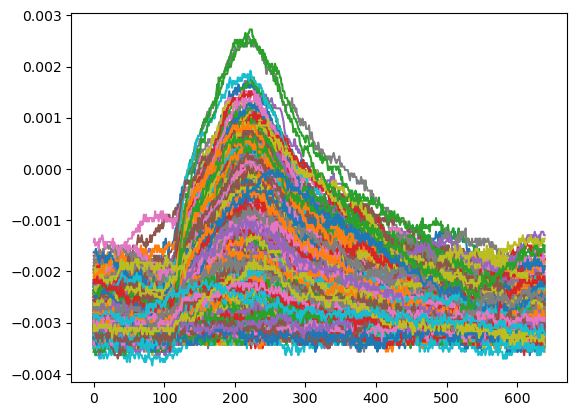

In [73]:
for i in range(1000):
    plt.plot(waveforms[:,1,i])
    #plt.ylim(-0.004,-0.002)

plt.savefig(r"C:\Users\louis\OneDrive\Documents\University of Manchester\Physics\Year 4\MPhys\mphys-lab-book\waveform_plot_101024.jpg")

In [74]:
print(np.min(waveforms[:,1,:]))

-0.0038358786405


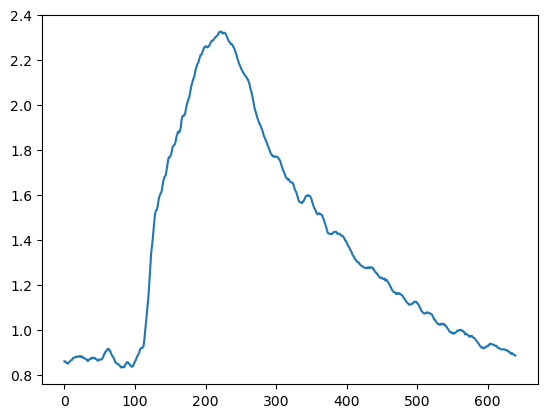

In [75]:
waveforms_sum = np.sum(waveforms, axis=2)
waveforms_sum -= np.min(waveforms[:,1,:]) * 1000

plt.plot(waveforms_sum[:,1])

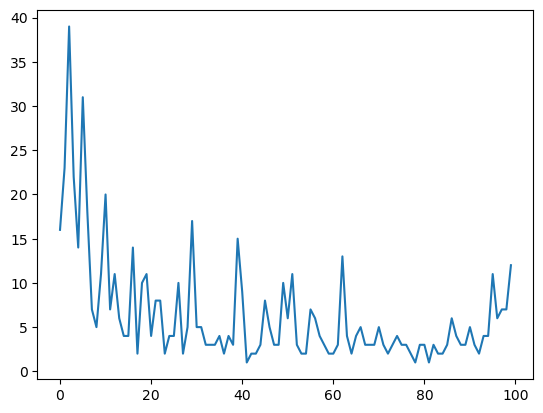

In [76]:
waveforms_sum_hist = np.histogram(waveforms_sum[:,1], bins=100)

plt.plot(waveforms_sum_hist[0])

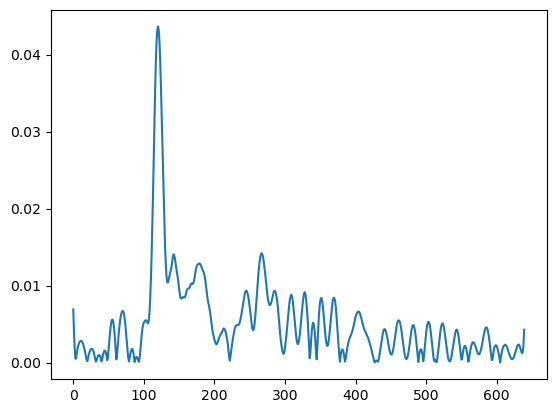

In [77]:
filtered_waveforms_sum = savgol_filter(waveforms_sum[:,1], 60, 10)
filtered_waveforms_sum_deriv = savgol_filter(waveforms_sum[:,1], 60, 9, deriv=1, delta=1)
#plt.plot(filtered_waveforms_sum)
plt.plot(np.abs(filtered_waveforms_sum_deriv))
#print(np.abs(filtered_waveforms_sum_deriv))
max = np.where(np.abs(filtered_waveforms_sum_deriv) == np.max(np.abs(filtered_waveforms_sum_deriv)))
min = np.where(np.abs(filtered_waveforms_sum_deriv) == np.min(np.abs(filtered_waveforms_sum_deriv)))
#min = np.where(filtered_waveforms_sum == np.min(filtered_waveforms_sum))
#max = np.where(filtered_waveforms_sum == np.max(filtered_waveforms_sum))
#plt.plot(max,filtered_waveforms_sum[max],"ro")
#plt.plot(min,filtered_waveforms_sum[min],"ro")


ROI:  (92, 352)


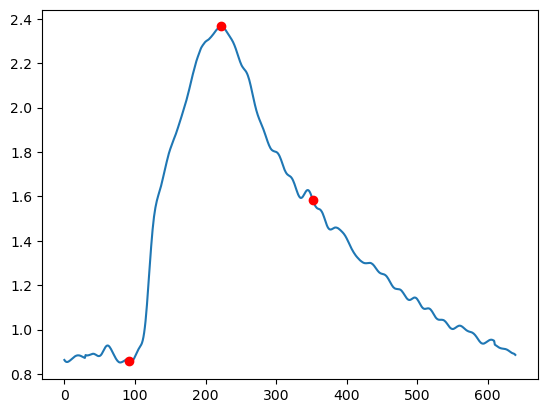

In [78]:
peak_loc = np.argmax(filtered_waveforms_sum)
min_loc = peak_loc-1

while min_loc >= 0:
    if filtered_waveforms_sum_deriv[min_loc] <= 0:
        break
    else:
        min_loc -= 1

plt.plot(filtered_waveforms_sum)
plt.plot(peak_loc,filtered_waveforms_sum[peak_loc],"ro")
plt.plot(min_loc,filtered_waveforms_sum[min_loc],"ro")
plt.plot(2*peak_loc-min_loc,filtered_waveforms_sum[2*peak_loc-min_loc],"ro")

print("ROI: ",(min_loc, 2*peak_loc-min_loc))

roi = [min_loc, 2*peak_loc-min_loc]

In [79]:
def plot1d(h, bins, ax=None, **plot_kwargs):
    '''
    Plots already binned data in a histogram
    Provide explicit axes to choose where to plot it, otherwise the current axes will be used'''
    if ax==None:
        ax = plt.gca() # get current axes
    # creating a list of the bin centers
    binw = bins[1]-bins[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins[:-1]]

    ax.bar(binc, h, width=binw, **plot_kwargs)
    return ax

In [80]:
print(len(all_waveforms[0][:,0]))

640


In [81]:
def determine_roi(all_waveforms, plot=False):
    """Determine the Region of Interest (ROI).  Locate the common peak in all waveforms 
    and the beginning of integration region.  An end value for the ROI is provided but is later 
    discarded.

    Parameters
    ----------
    all_waveforms : list of 2d np arrays
        list with each entry being a 2d np array describing a waveform with columns (time, amplitude)
    plot : bool, optional
        plot the determined roi or not, by default False

    Returns
    -------
    int, int, int
        indices of begin of ROI, end of ROI, location of peak
    """
    time = []
    amplitude = []
    bins = len(all_waveforms[0][:,0])
    
    print("Determining ROI...")
    for index, waveform in tqdm(enumerate(all_waveforms)):
        for index_inner, single_point in enumerate(waveform):
            time.append(single_point[0])
            amplitude.append(single_point[1])

    #for i in range(640):
    #    time.append(all_waveforms[0][i,0])
    #    amplitude.append(all_waveforms[0][i,1])
    
    #print(time)
    #print(amplitude)
    
    smallest = np.min(amplitude)
    amplitude = amplitude + np.abs(smallest)

    time = np.array(time)
    time *= 10**9

    print(len(amplitude))

    hist, edges = np.histogram(time, bins, weights=amplitude)
    plot1d(hist, edges, alpha= 0.2, label='raw signal')
    hist_filtered = savgol_filter(hist, 60, 9)
    hist_deriv = savgol_filter(hist, 60, 9, 1, edges[1] - edges[0])
    visual_extrema = np.where(np.abs(hist_deriv) <= np.max(hist_deriv)/30, hist_filtered, np.full(np.shape(hist), np.nan))
    plot1d(hist_filtered, edges, alpha = 0.2, color='r', label='smoothed signal')
    plt.scatter(get_bin_centres(edges), visual_extrema,  color='r')
    
    numerical_extrema = np.where(np.isnan(visual_extrema) , np.zeros(np.shape(visual_extrema)), visual_extrema)
    
    max_loc = np.argmax(numerical_extrema)
    plt.scatter(get_bin_centres(edges)[max_loc], visual_extrema[max_loc], color='r')
    print(visual_extrema[max_loc])

    #define some dummy variables to find the peak before 
    iterator = max_loc
    activate = False
    roi_begin = 0

    while iterator >= 0:

        if(numerical_extrema[iterator] == 0):
            activate = True
        
        else:
            if activate == True:
                roi_begin = iterator
                break


        iterator -= 1


    plt.scatter(get_bin_centres(edges)[roi_begin], visual_extrema[roi_begin], color='r')

    #For the upper ROI limit just take 3 times the 
    diff = max_loc - roi_begin
    roi_end = max_loc + 1 * diff
    

    plt.scatter(get_bin_centres(edges)[roi_end], hist_filtered[roi_end], color='r')
    plt.xlabel("time[ns]", fontsize = 18)
    plt.ylabel("Summed signal[V]", fontsize = 18)
    #plt.title("ROI determination")
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    

    if plot==True:
        #plt.savefig("PLOTS_FOLDER + ROI_example_sipm.png", dpi=600)
        plt.show()
    plt.cla()
    print("ROI determined to be [{0}:{1}]".format(roi_begin, roi_end))

    return roi_begin, roi_end, max_loc

In [82]:
def get_bin_centres(bins_edges, dtype='list'):
    binw = bins_edges[1]-bins_edges[0] # assuming equal spaced bins
    binc = [ b + binw/2 for b in bins_edges[:-1]]
    if dtype == 'ndarray':
        binc = np.array(binc)
    return binc

Determining ROI...


1000it [00:00, 3269.84it/s]


640000
1.5972061342583095


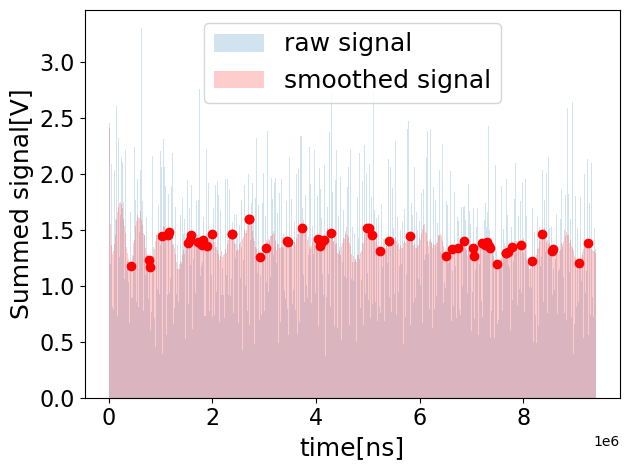

ROI determined to be [162:206]


(162, 206, 184)

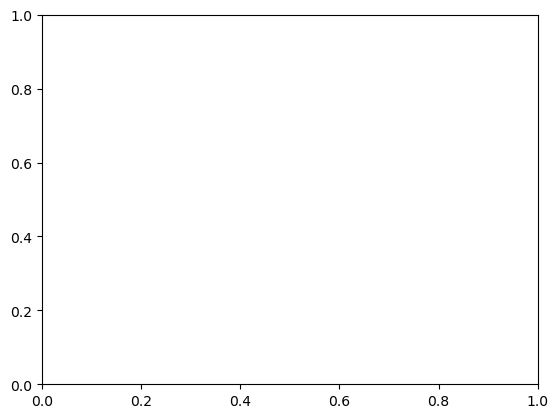

In [83]:
determine_roi(all_waveforms, plot=True)

In [106]:
def filter_outliers(all_waveforms, max_loc, roi=[], plot=False):
    """Filters waveforms that peak away from the predetermined peak

    Parameters
    ----------
    all_waveforms : list of ndarray
        a list containing all waveforms, each waveform is an ndarray with first column time[s]
        and second column amplitude[V]
    max_loc : int
        index of the peak in every waveform
    roi : list, optional
        begin and end indices of the roi, by default []
    plot : bool, optional
        plot the waveforms or not, by default False

    Returns
    -------
    list of ndarray
        list of filtered waveforms
    """    
    filtered_waveforms = []
    double_filtered_waveforms = []
    trash = []  #use for testing
    max_diff = 0
    all_baseline_vars = []
    all_diff = []
    trashed_var = 0
    print("Calculating average values...")
    for index, waveform in tqdm(enumerate(all_waveforms)):
        maximum_value_loc = np.argmax(waveform[:, 1])

        
        max_value = np.max(waveform[:, 1])
        min_value = np.min(waveform[:, 1])
        diff = max_value - min_value
        all_diff.append(diff)
        if diff > max_diff:
            max_diff = diff
        
        """
        if diff < max_diff / 10:
            filtered_waveforms.append(waveform)
            continue
        """
        baseline_var = np.var(waveform[:roi[0], 1])
        all_baseline_vars.append(baseline_var)


        """
        if(maximum_value_loc < roi[1] and maximum_value_loc > roi[0]):


            if np.abs(maximum_value_loc - max_loc) > (max_loc - roi[0])*0.7:
                trash.append(waveform)
                continue
            filtered_waveforms.append(waveform)
            continue
        trash.append(waveform)
        """

    average_diff = np.average(all_diff)
    average_baseline_var = np.average(all_baseline_vars)
    baseline_var_cut = np.quantile(all_baseline_vars, 1.00)
    #print(baseline_var_cut)
    
    print("Eliminating outliers...")
    for index1, waveform1 in tqdm(enumerate(all_waveforms)):
        maximum_value_loc = np.argmax(waveform1[:, 1])
        max_value = np.max(waveform1[:, 1])
        min_value = np.min(waveform1[:, 1])
        diff = max_value - min_value
        if diff < average_diff / 2:
            filtered_waveforms.append(waveform1)
            continue
        
        baseline_var = np.var(waveform1[:roi[0], 1])
        if baseline_var > baseline_var_cut:
            trash.append(waveform1)
            trashed_var += 1
            continue
        
        if(maximum_value_loc < roi[1] and maximum_value_loc > roi[0]):


            if np.abs(maximum_value_loc - max_loc) > (max_loc - roi[0])*0.7:
                trash.append(waveform1)
                continue
            filtered_waveforms.append(waveform1)
            continue
        trash.append(waveform1)

        



    if plot == True:
        #make_heatmap(filtered_waveforms)

        #make_heatmap(trash[10:12], True, "example_filtered.png")
        plot_indices = [10, 11]
        lim_max = np.max(np.vstack(filtered_waveforms)[:, 1])
        lim_min = np.min(np.vstack(filtered_waveforms)[:, 1])
        for index in plot_indices:
            plt.plot(trash[index][:, 0], trash[index][:, 1])
        plt.ylim(bottom=lim_min, top=lim_max)
        plt.show()
        #np.savetxt("/home/todor/University/MPhys project/MPhys_project/analyze-lecroy/data/rejected_waveforms_example.csv", np.vstack(trash), delimiter=',')
    
    print("Total entries left after filtering: {}".format(len(filtered_waveforms)))
    
    return filtered_waveforms

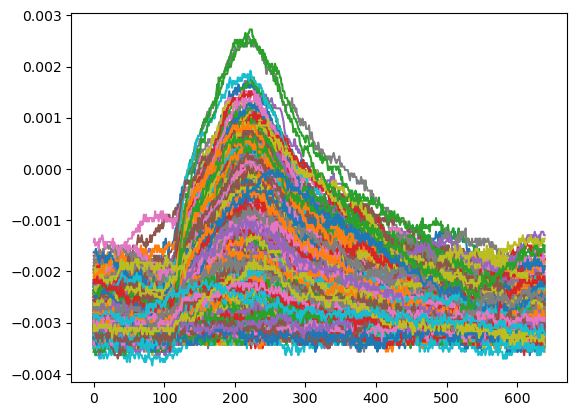

In [85]:
for i in range(1000):
    plt.plot(all_waveforms[i][:,1])

In [107]:
filtered_waveforms = filter_outliers(all_waveforms, peak_loc, roi, plot=False)

Calculating average values...


1000it [00:00, 16749.28it/s]


Eliminating outliers...


1000it [00:00, 22843.80it/s]

Total entries left after filtering: 98


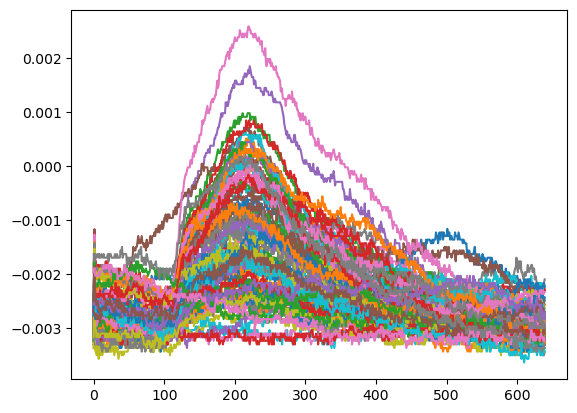

In [110]:
for i in range(len(filtered_waveforms)):
    plt.plot(filtered_waveforms[i][1,:])

In [95]:
def mirror_crystalball(x, beta, m, loc, scale, norm, offset):
    result = crystalball.pdf(-x, beta, m, -loc, scale) * norm + offset
    return result


def linear(x, a, b):
    return a * x + b


def norm_gaus(x, loc, sigma, normalisation):
    return norm.pdf(x, loc, sigma) * normalisation





def chi2(data, model, unc, no_params=21):
    """A function to calculate the chi^2.  Can be replaced with Minuit.cost.LeastSquares

    Parameters
    ----------
    data : list
        experimental data
    model : list
        theoretical values
    unc : list
        errors in the theoretical values
    no_params : int, optional
        number of parameters for reduced chi^2 calculation, by default 21

    Returns
    -------
    float
        chi^2
    """
    chi2 = np.sum((data - model)**2 / unc**2)
    chi2_per_DoF = chi2 / (len(data) - no_params)
    print("Chi2 : {0} and chi2 per DoF : {1}".format(chi2, chi2_per_DoF))
    return chi2

def plot2d(h, xbins, ybins, ax=None, **plot_kwargs):
    '''
    Plots already binned data in a histogram
    Provide explicit axes to choose where to plot it, otherwise the current axes will be used'''
    if ax is None:
        ax = plt.gca()  # get current axes
    
    im = ax.matshow(h.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], aspect='auto', origin='lower', **plot_kwargs)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    return im  # Return the mappable object


In [100]:
def make_heatmap(all_waveforms, save=False, savename="initial_data_reading_10x1000waveforms_heatmap.png", plot_title=False, title="Recorded waveforms for a single SiPM at 56V bias"):
    """Make a heatmap of the waveforms (faster than plotting all waveforms)

    Parameters
    ----------
    all_waveforms : list<numpy.array>
        a list of numpy arrays with each array being 1 waveform with timepoints in the 0th column and amplitudes in the 1st column
    save : bool, optional
        save the figure or not, by default False
    savename : str, optional
        name of the file to save, by default "initial_data_reading_10x1000waveforms_heatmap.png"
    """
    time = []
    amplitude = []
    print("Making a heatmap...")
    for index, waveform in tqdm(enumerate(all_waveforms)):
        for index_inner, single_point in enumerate(waveform):
            time.append(single_point[0])
            amplitude.append(single_point[1])

    time = np.array(time)
    time *= 10**9
    amplitude = np.array(amplitude)
    amplitude *= 10**3
        
    
    
    image, x_edges, y_edges = np.histogram2d(time, amplitude, bins=[400, 300])
    image = np.where(image == 0, np.full(np.shape(image), np.nan), image)
    
    fig = plt.figure(figsize=(12, 9))
    axes = fig.add_subplot()

    im = plot2d(image, x_edges, y_edges, axes, norm=matplotlib.colors.LogNorm())
    axes.set_xlabel('time[ns]', fontsize=22)
    axes.set_ylabel("Amplified signal[mV]", fontsize=22)
    axes.tick_params(axis='both', which='major', labelsize=18)
    axes.tick_params(axis='both', which='minor', labelsize=18)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label("Observed Frequency", fontsize=22)
    cax.tick_params(axis='both', which='both', labelsize=18)
    fig.tight_layout()
    
    
    if plot_title == True:
        axes.set_title(title, fontsize=22)

    if save == True:
        loc = PLOTS_FOLDER
        fig.savefig(loc + savename, dpi=600)

    plt.show()

In [101]:
def find_area(selected_waveforms, roi=[], no_bins=150, plot=False, save=False, save_loc=DATA_FOLDER, savename="areas_sipm-1_56V_sl.csv"):
    """
    Filters waveforms that have high slope in the baseline region (top and bottom 10%) 
    Calculates integration limits for all waveforms (non-flat ones)
    Shifts all waveforms to 0
    Integrates in the determined regions all waveforms (or up until the average of other regions)
    Saves all areas to a file

    Parameters
    ----------
    selected_waveforms : list of ndarray
        a list containing all waveforms after first filter, each waveform is an ndarray with first column time[s]
        and second column amplitude[V]
    roi : list, optional
        begin and end indices of roi(the end is discarded, only used as an initial estimation), by default []
    no_bins : int, optional
        number of bins in histogram, by default 150
    plot : bool, optional
        show plots of waveforms after filtering and shifting and areas histogram, by default False
    save : bool, optional
        save the areas to csv file or not, by default False
    save_loc : str, optional
        location of the saved csv, by default DATA_FOLDER
    savename : str, optional
        filename of the areas csv, by default "areas_sipm-1_56V_sl.csv"

    Returns
    -------
    list<float>, ndarray, ndarray
        list of all areas, histogrammed areas, bins of the histogram
    """    
    areas = []
    #all_amplitudes = np.array([])
    shifted_waveforms = []
    negative_waveforms = []
    negative_var = []
    slopes = []
    print("Calculating areas...")
    roi_upper_all = [roi[1]]

    for index_1, waveform_1 in enumerate(selected_waveforms):
        #looking for minimum
        baseline = np.average(waveform_1[:roi[0], 1])
        waveform_1[:, 1] -= baseline
        #if(- np.min(waveform_1[:, 1]) < np.max(waveform_1[:, 1] / 0.75)):
            #shifted_waveforms.append(waveform_1)
        
        popt, pcov = curve_fit(linear, waveform_1[:roi[0], 0], waveform_1[:roi[0], 1])
        slopes.append(popt[0])
        """
        below_zero = np.flatnonzero(waveform_1[:, 1] < 0)
        if len(below_zero) < len(waveform_1[:, 1]) /2:

            shifted_waveforms.append(waveform_1)
        else:
            negative_waveforms.append(waveform_1)
            negative_var.append(np.var(waveform_1[:, 1]))
        """
        roi_effective = list(roi)
        peak_loc = np.argmax(waveform_1[:, 1])
        
        
        tail_indices = np.flatnonzero(waveform_1[peak_loc:, 1] <= np.max(waveform_1[:, 1]) * 0.1)
        if(tail_indices.size == 0):
            tail_indices = [0]
        tail_indices += peak_loc
        if tail_indices[0] > roi_effective[1]:
            
            roi_effective[1] = deepcopy( tail_indices[0])
            roi_upper_all.append(roi_effective[1])

        #all_amplitudes = np.append(all_amplitudes, waveform_1[:, 1])
    #var_cut = np.quantile(negative_var, 0.65)
    slope_cut_max = np.quantile(slopes, 0.9)
    slope_cut_min = np.quantile(slopes, 0.1)
    for index_2, waveform_2 in enumerate(selected_waveforms):
        if(slopes[index_2] <= slope_cut_max and slopes[index_2] >= slope_cut_min):
            shifted_waveforms.append(waveform_2)
        else:
            negative_waveforms.append(waveform_2)

    if plot == True:
        make_heatmap(shifted_waveforms, True, "shifted_waveforms_sipm-411_56V.png", False, "Waveforms after filtering for a single PMT at 850V")
        
    #shift = - np.min(all_amplitudes)
    
    #negative_waveforms = []
    
    for index, waveform in tqdm(enumerate(shifted_waveforms)):
        #waveform[:, 1] = waveform[:, 1] + shift #shift to above 0 before integration

        roi_effective = list(roi)
        peak_loc = np.argmax(waveform[:, 1])
        tail_indices = np.flatnonzero(waveform[peak_loc:, 1] <= np.max(waveform[:, 1]) * 0.1)
        if(tail_indices.size == 0):
            tail_indices = [0]
        tail_indices += peak_loc
        #print(tail_indices[0])
        if tail_indices[0] > roi_effective[1]:
            
            roi_effective[1] = deepcopy( tail_indices[0])
            
            
            #print(roi_effective)
        else:
            roi_effective[1] = int(np.average(roi_upper_all))
        
        integral = np.trapz(waveform[roi_effective[0]:roi_effective[1], 1], waveform[roi_effective[0]:roi_effective[1], 0], waveform[1, 0] - waveform[0, 0])
        areas.append(integral)
        if integral < 7e-11 and integral > 3e-11:
            #negative_waveforms.append(waveform)
            continue

    print("New ROI upper limit changed from {0} to {1}".format(roi[1], np.average(roi_upper_all)))  #check which roi limit is better
    

    hist, bins = np.histogram(areas, no_bins)
    if plot == True:
        plot1d(hist, bins)
        plt.xlabel("Charge[nV.s]")
        plt.ylabel("Entries[0.3 counts/(nV.ms)]")
        plt.title("Charge for a single PMT")
        plt.savefig(PLOTS_FOLDER + "areas_example_sipm.png", dpi=600)
        plt.show()
        #make_heatmap(negative_waveforms, True, "cancelled_waveforms.png")
        #np.savetxt("/home/todor/University/MPhys project/MPhys_project/analyze-lecroy/data/cancelled_waveforms_example_2.csv", np.vstack(negative_waveforms), delimiter=',')
    
    if save == True:
        fname = save_loc + savename
        np.savetxt(fname, areas, delimiter=',')
        print("Areas saved to file at: " + fname)

    return areas, hist, bins

c:\Users\louis\anaconda3\envs\vuv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Calculating areas...
Making a heatmap...


78it [00:00, 77931.33it/s]


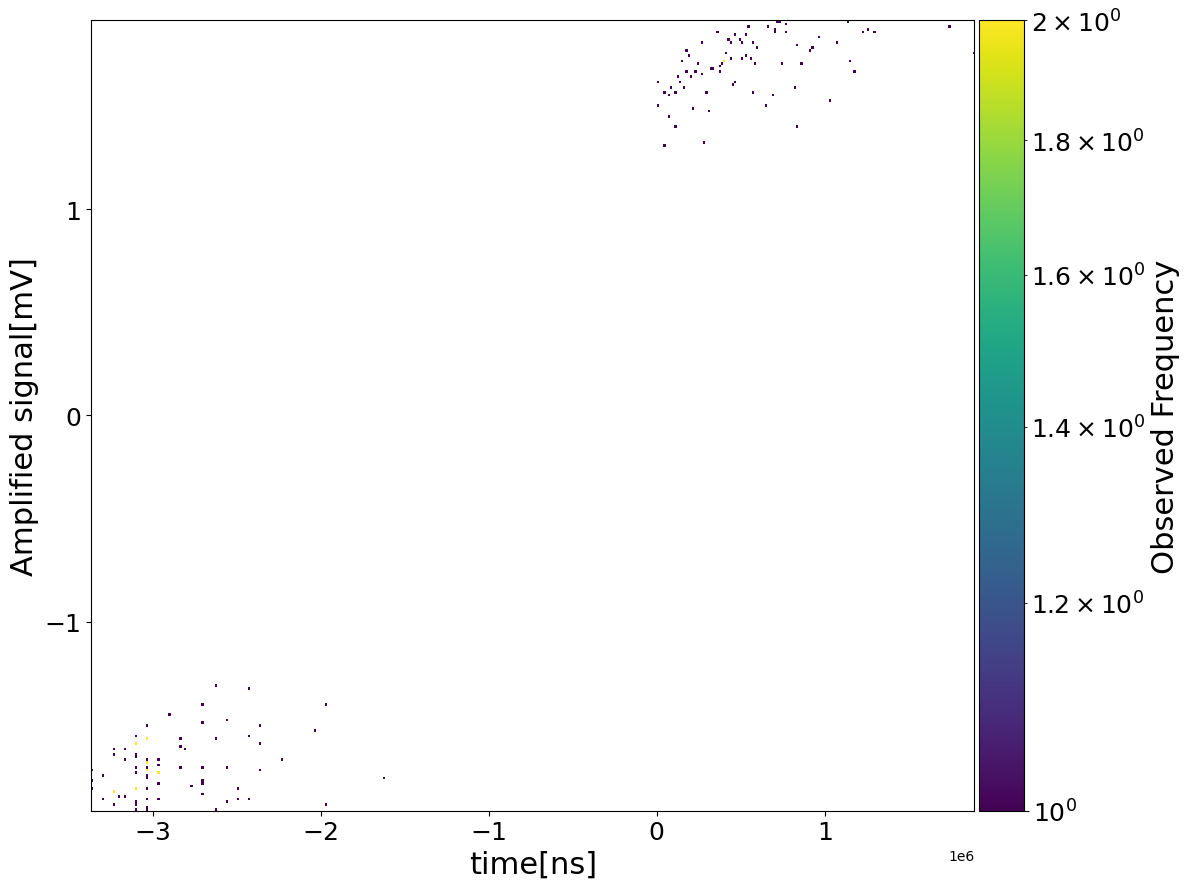

78it [00:00, ?it/s]


New ROI upper limit changed from 352 to 352.0


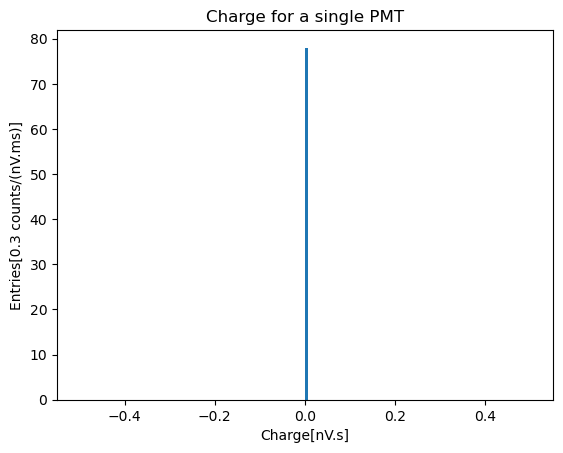

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  

In [109]:
find_area(filtered_waveforms, roi, no_bins=150, plot=True, save=False, save_loc=DATA_FOLDER, savename="test.csv")